In [95]:
import sys
sys.path.append('./../NeuroDataResource/')

import pickle
import numpy as np
from scipy.signal import correlate2d
from matplotlib import pyplot as plt
from NeuroDataResource import NeuroDataResource
from skimage.filters.rank import maximum as max_filter
from skimage.filters.rank import median as median_filter
from skimage.filters.rank import minimum as min_filter
from skimage.measure import block_reduce as pool
from skimage.measure import label
from scipy.spatial.distance import euclidean as l2_dist
from skimage.filters import threshold_otsu
from sklearn.neighbors import KDTree

In [2]:
token = pickle.load(open('./../NeuroDataResource/data/token.pkl', 'rb'))

In [3]:
myResource = NeuroDataResource(host = 'api.boss.neurodata.io',
                               token = token,
                               collection = 'collman',
                               experiment = 'collman15v2',
                               chanList = [{'name': 'annotation', 'dtype': 'uint64'},
                                           {'name': 'EM25K', 'dtype':'uint8'},
                                           {'name': 'GABA488', 'dtype':'uint8'},
                                           {'name': 'GAD647', 'dtype':'uint8'},
                                           {'name': 'gephyrin594', 'dtype':'uint8'},
                                           {'name': 'GS594', 'dtype':'uint8'},
                                           {'name': 'MBP488', 'dtype':'uint8'},
                                           {'name': 'NR1594', 'dtype':'uint8'},
                                           {'name': 'PSD95_488', 'dtype':'uint8'},
                                           {'name': 'Synapsin647', 'dtype':'uint8'},
                                           {'name': 'VGluT1_647', 'dtype':'uint8'}
                                          ])

In [5]:
cutouts = {}
for key in myResource._chanList.keys():
    if not 'EM' in key:
        print(key)
        cutout = myResource.get_cutout(chan=key, zRange=[0, 20], yRange=[1000, 2000], xRange=[1000, 2500])
        cutouts[key] = cutout

VGluT1_647
GABA488
GAD647
MBP488
PSD95_488
NR1594
annotation
gephyrin594
Synapsin647
GS594


In [7]:
preSyn = np.stack([cutouts['Synapsin647'],
                   cutouts['VGluT1_647'],
                   cutouts['GAD647']])

postSyn = np.stack([cutouts['PSD95_488'],
                    cutouts['GABA488'],
                    cutouts['gephyrin594']])

# Pre-Alpha 0.0.1

In [68]:
preSynAve = np.mean(preSyn, axis=0)
postSynAve = np.mean(postSyn, axis=0)
annot = cutouts['annotation']

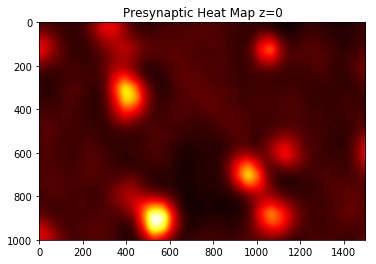

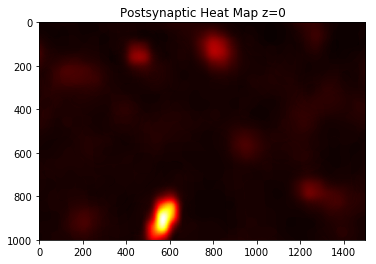

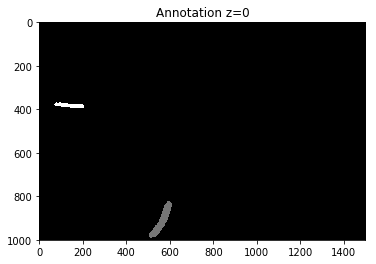

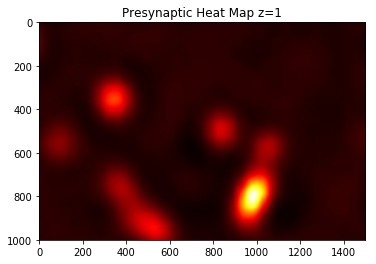

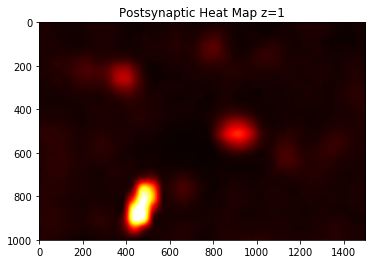

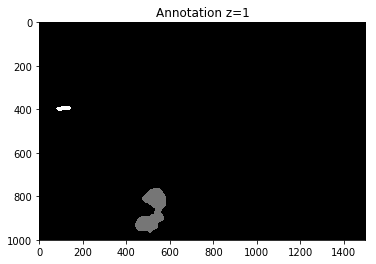

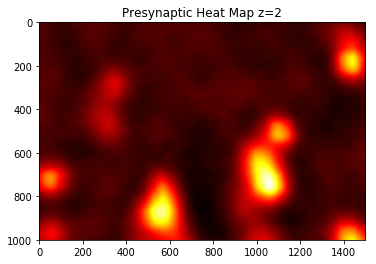

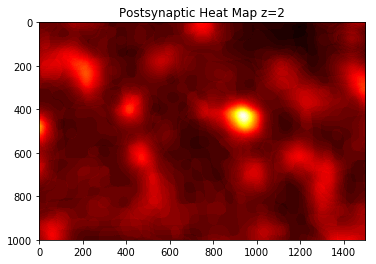

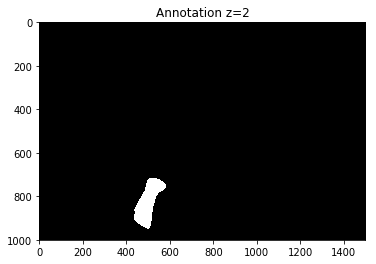

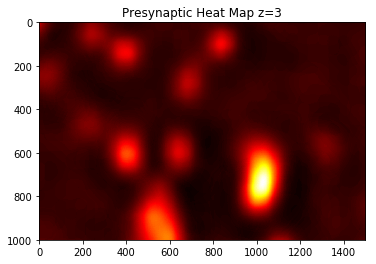

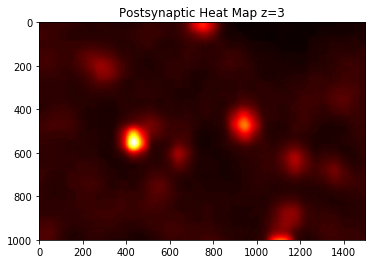

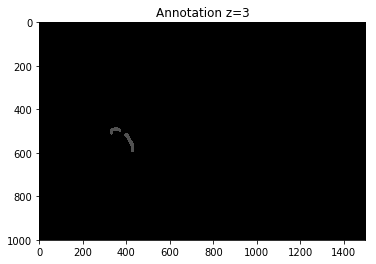

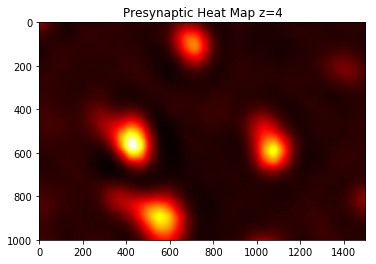

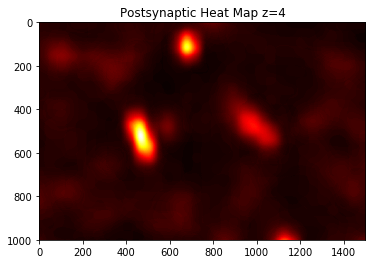

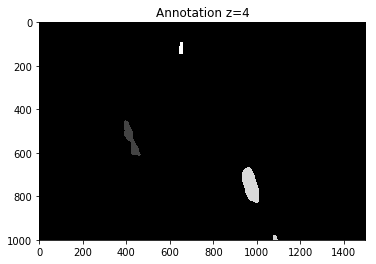

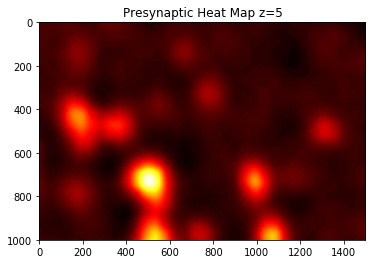

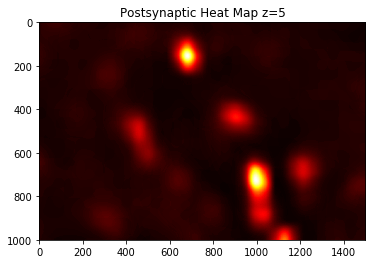

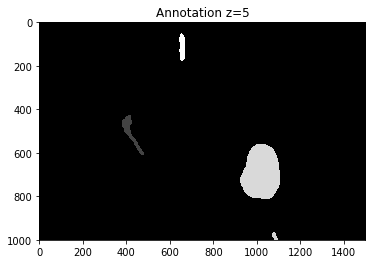

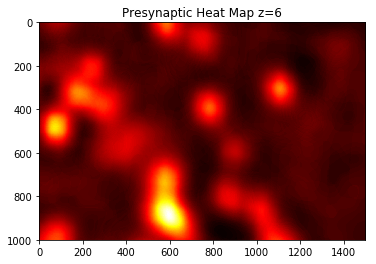

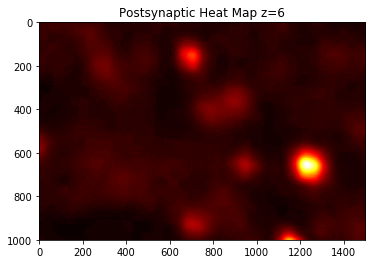

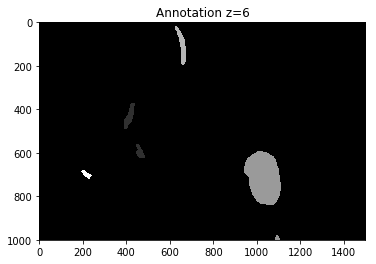

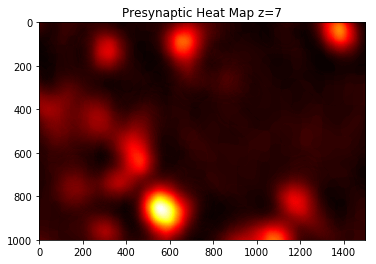

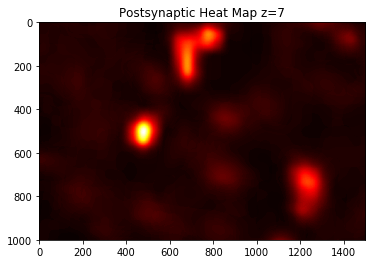

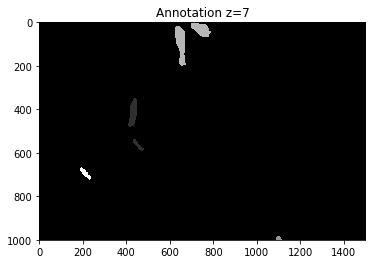

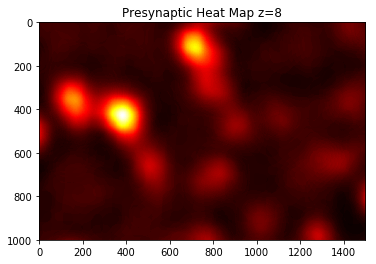

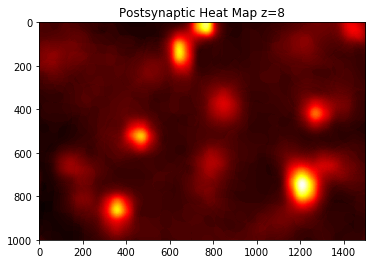

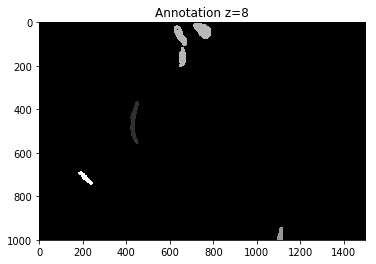

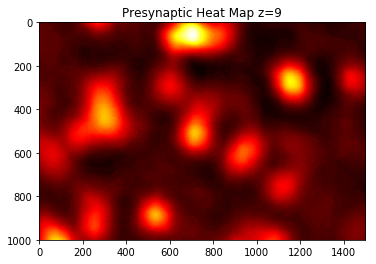

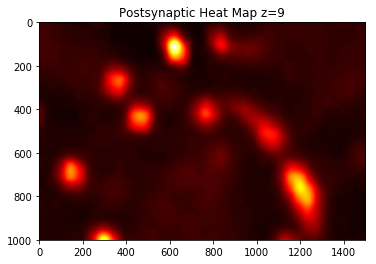

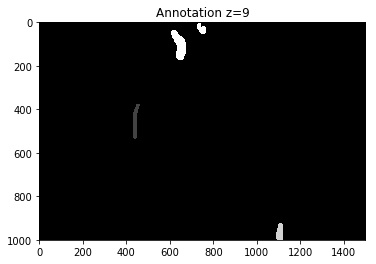

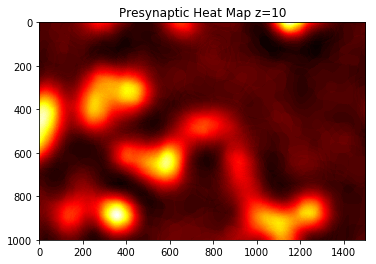

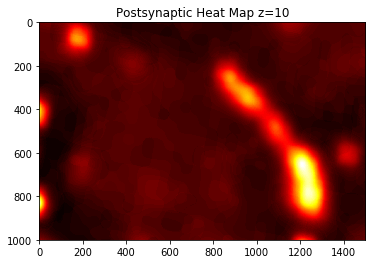

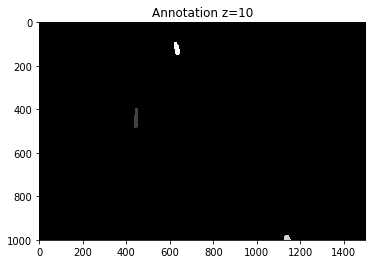

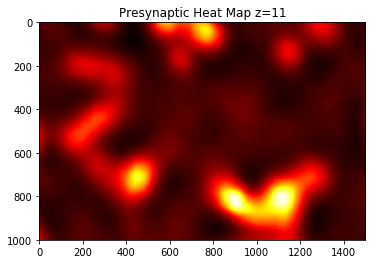

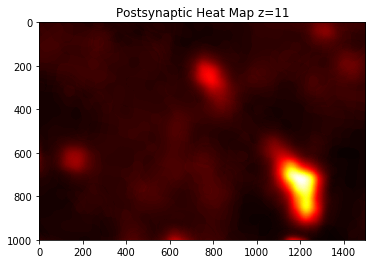

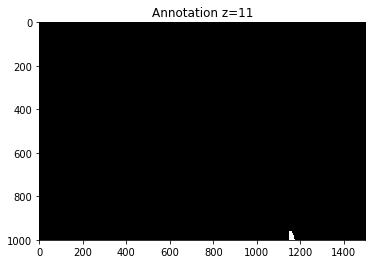

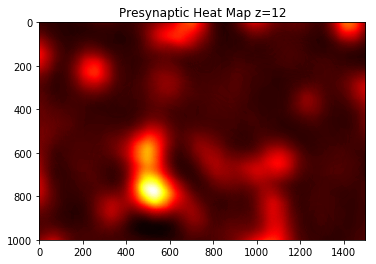

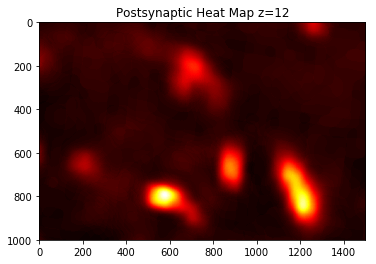

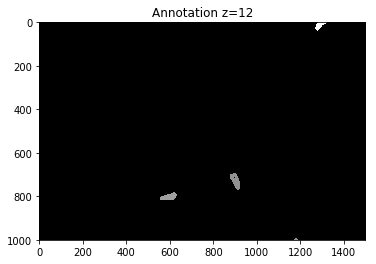

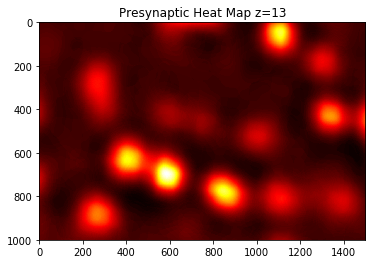

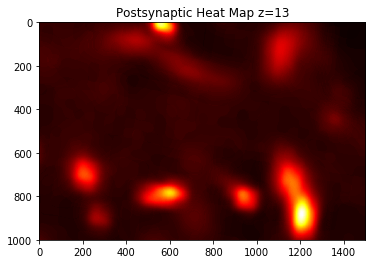

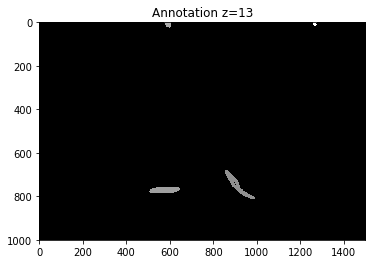

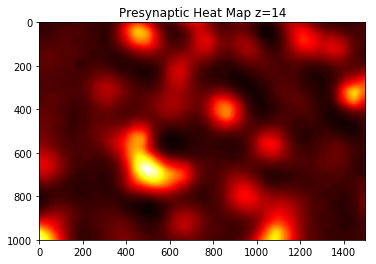

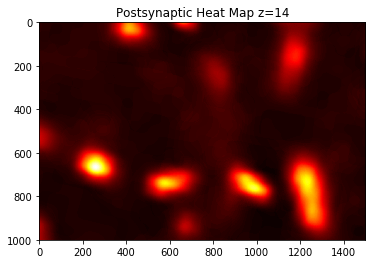

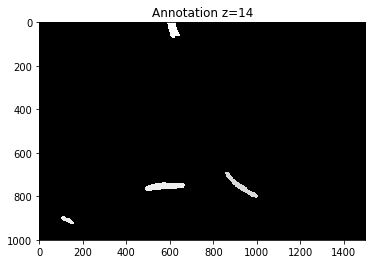

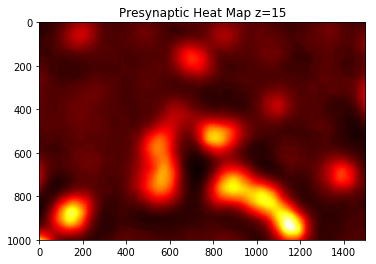

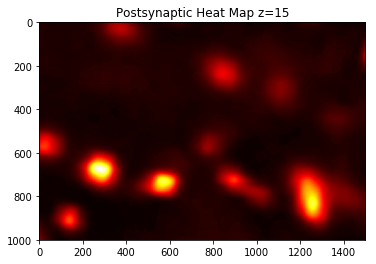

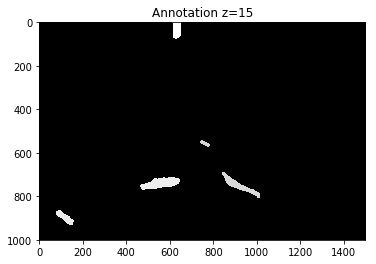

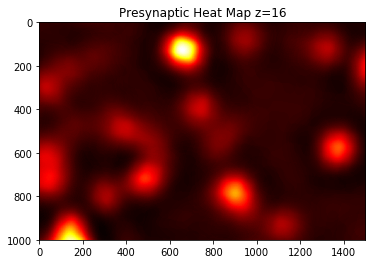

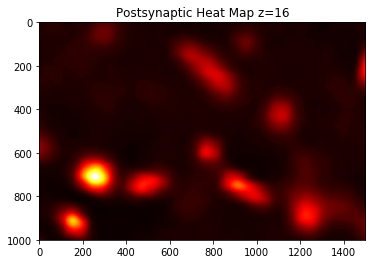

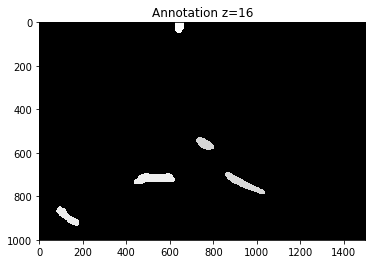

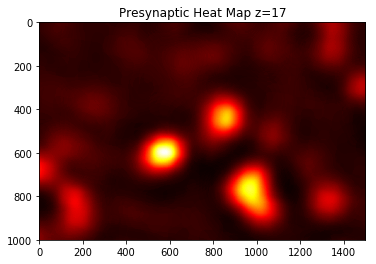

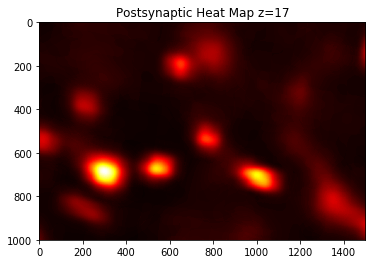

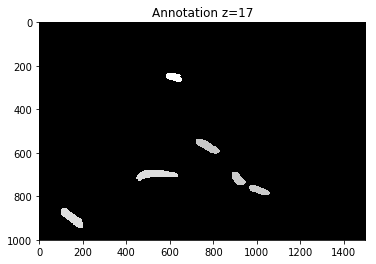

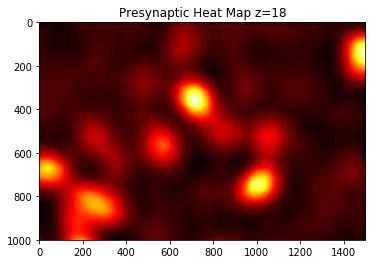

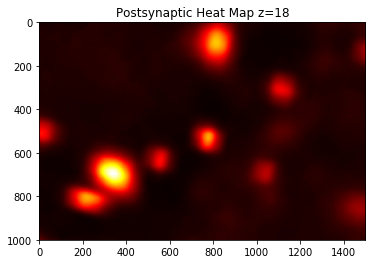

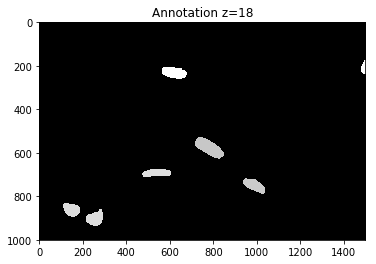

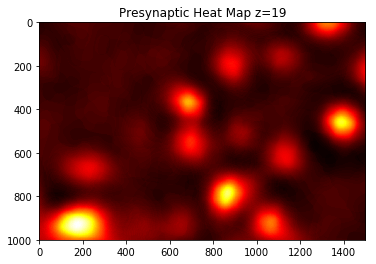

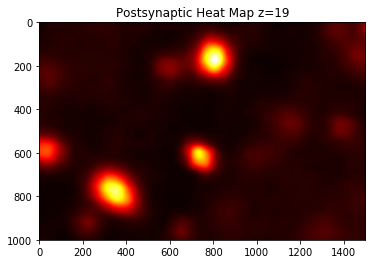

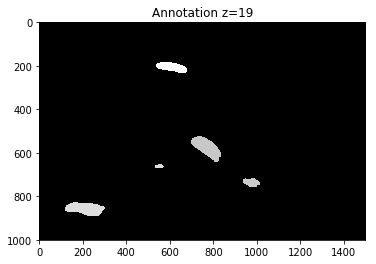

In [70]:
for z in range(preSynAve.shape[0]):
    plt.figure()
    plt.title('Presynaptic Heat Map z=' + str(z))
    plt.imshow(preSynAve[z], cmap='hot')
    plt.show()
    
    plt.figure()
    plt.title('Postsynaptic Heat Map z=' + str(z))
    plt.imshow(postSynAve[z], cmap='hot')
    plt.show()
    
    plt.figure()
    plt.title('Annotation z=' + str(z))
    plt.imshow(annot[z], cmap='gray')
    plt.show()

In [71]:
def max_sum_filter(pre, post):
    struct = np.ones((5, 5))
    max_pre = max_filter(pre, struct)
    max_post = max_filter(post, struct)
    return np.add(max_pre, max_post)

def difference_filter(img):
    struct = np.ones((5, 5))
    max_img = max_filter(img, struct)
    min_img = median_filter(img, struct)
    return np.subtract(max_img, min_img)

def min_max_filter(img):
    struct = np.ones((5, 5))
    return max_filter(min_filter(img, struct), struct)

In [72]:
testPre = preSynAve[0]
testPost = postSynAve[0]

In [73]:
max_sum_filter(testPre/np.max(testPre), testPost/np.max(testPost))

/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


array([[ 78,  78,  78, ...,  72,  72,  72],
       [ 78,  78,  78, ...,  72,  72,  72],
       [ 79,  79,  79, ...,  72,  72,  72],
       ..., 
       [117, 117, 118, ...,  94,  94,  94],
       [117, 117, 117, ...,  94,  94,  94],
       [117, 117, 117, ...,  94,  94,  94]], dtype=uint8)

/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


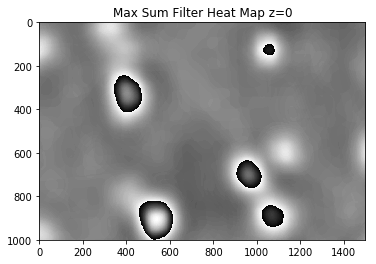

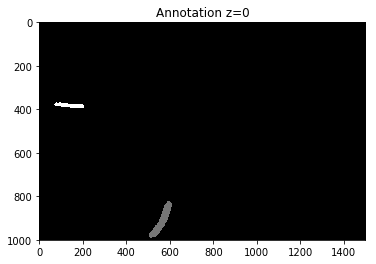

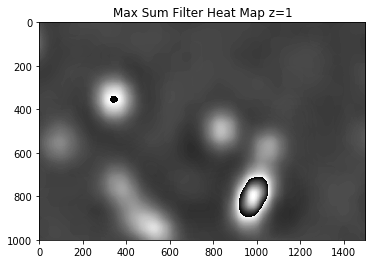

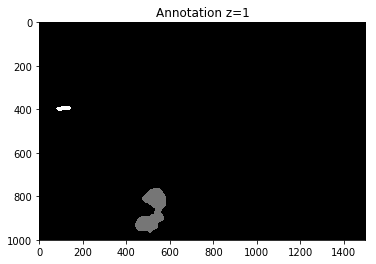

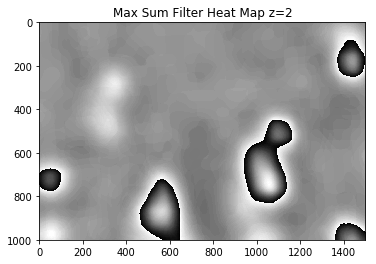

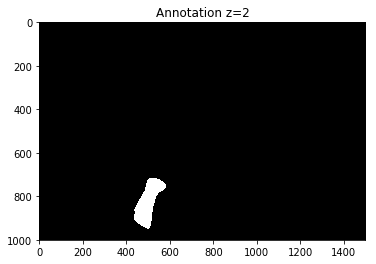

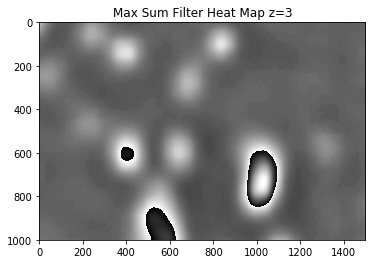

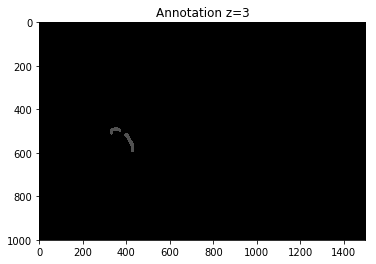

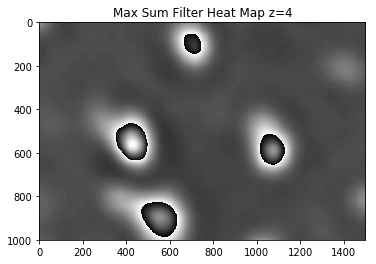

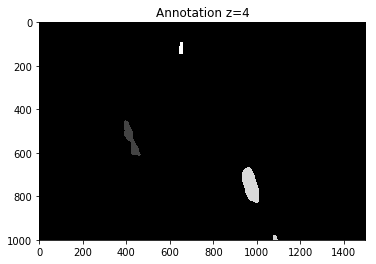

In [74]:
#for z in range(preSynAve.shape[0]):
for z in range(5):
    plt.figure()
    plt.title('Max Sum Filter Heat Map z=' + str(z))
    normPreSyn = preSynAve[z]/np.max(preSynAve[z])
    normPostSyn = preSynAve[z]/np.max(preSynAve[z])
    maxSum = max_sum_filter(normPreSyn, normPostSyn)
    plt.imshow(maxSum, cmap='gray')
    plt.show()
    
    plt.figure()
    plt.title('Annotation z=' + str(z))
    plt.imshow(annot[z], cmap='gray')
    plt.show()

/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


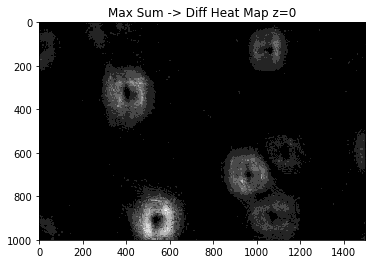

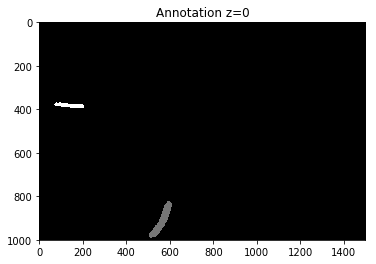

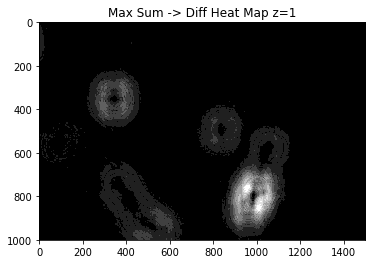

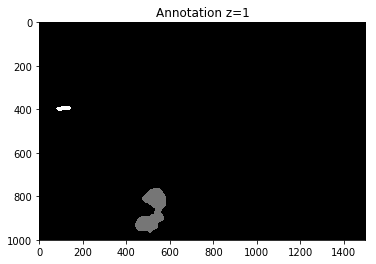

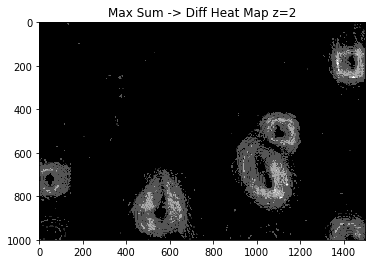

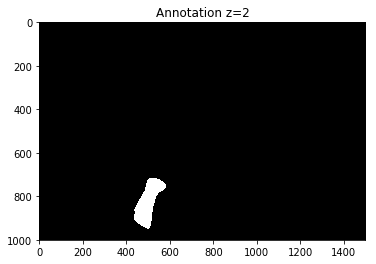

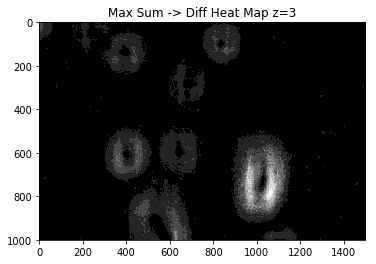

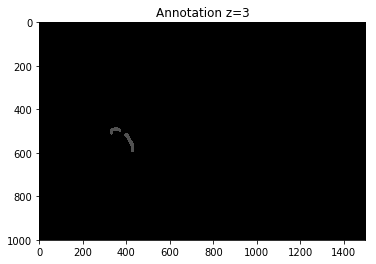

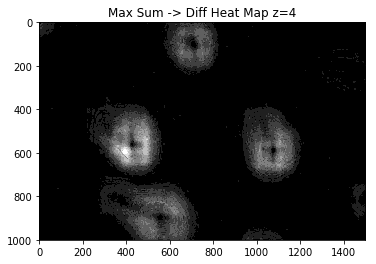

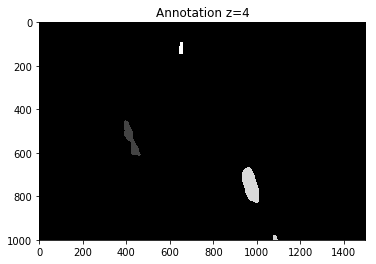

In [77]:
for z in range(5):
    plt.figure()
    plt.title('Max Sum -> Diff Heat Map z=' + str(z))
    
    normPreSyn = preSynAve[z]/np.max(preSynAve[z])
    normPostSyn = preSynAve[z]/np.max(preSynAve[z])
    maxSum = max_sum_filter(normPreSyn, normPostSyn)
    diff = difference_filter(maxSum)
    minMax = min_max_filter(diff)
    
    plt.imshow(minMax , cmap='gray')
    plt.show()
    
    plt.figure()
    plt.title('Annotation z=' + str(z))
    plt.imshow(annot[z], cmap='gray')
    plt.show()

These results are promising -> I would like to find a smarter way to reduce the inputs for the presynaptic and postsynaptic to one volume than a simple sum/average. 

# Pre-Alpha 0.0.2
#### We have a direction

In [9]:
def whiten_chan(img):
    sigma = np.std(img)
    mu = np.average(img)
    return (img - mu)/sigma

In [10]:
w_presyn = [whiten_chan(elem) for elem in preSyn]
w_postsyn = [whiten_chan(elem) for elem in postSyn]

In [11]:
ave_presyn = np.mean(np.stack(w_presyn), axis=0)
ave_postsyn = np.mean(np.stack(w_postsyn), axis=0)

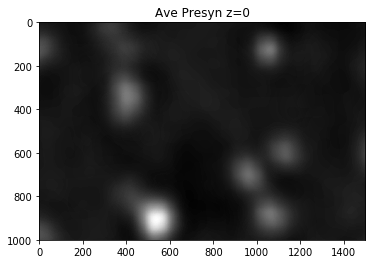

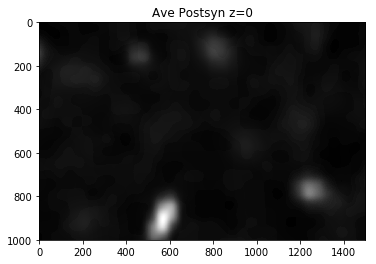

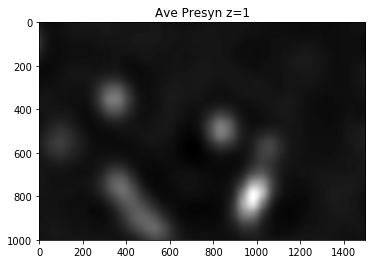

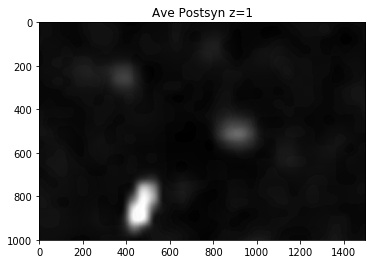

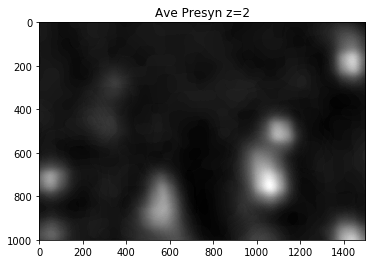

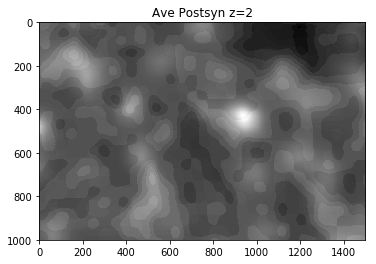

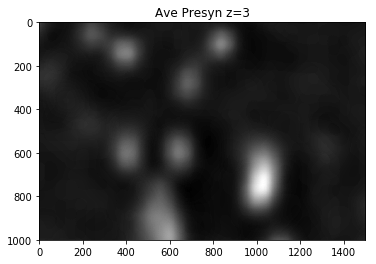

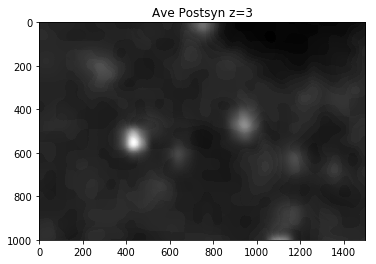

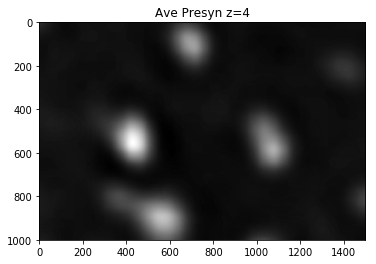

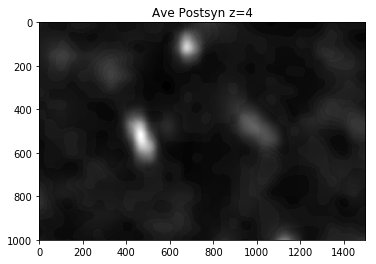

In [12]:
for i in range(5):
    plt.figure()
    plt.title('Ave Presyn z=' + str(i))
    plt.imshow(ave_presyn[i], cmap='gray')
    plt.show()
    
    plt.figure()
    plt.title('Ave Postsyn z=' + str(i))
    plt.imshow(ave_postsyn[i], cmap='gray')
    plt.show()

In [19]:
rgb = np.moveaxis(np.stack([ave_presyn[0:2], np.zeros_like(ave_presyn[0:2]), ave_postsyn[0:2]]),0, -1)

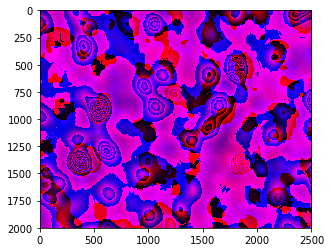

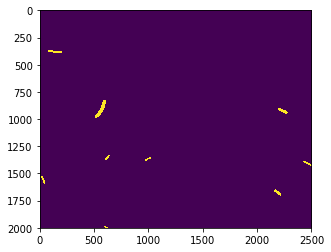

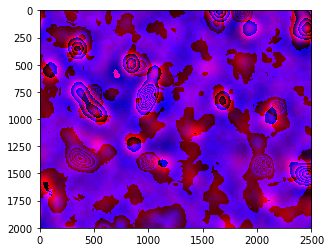

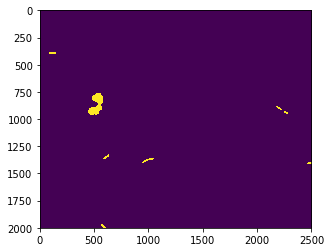

In [20]:
for i in range(2):
    plt.figure()
    plt.imshow(rgb[i])
    plt.show()

    plt.figure()
    plt.imshow(annot[i] > 0)
    plt.show()

In [32]:
downsample_presyn = [pool(elem, (2, 2), np.max) for elem in ave_presyn]
downsample_postsyn = [pool(elem, (2, 2), np.max) for elem in ave_postsyn]

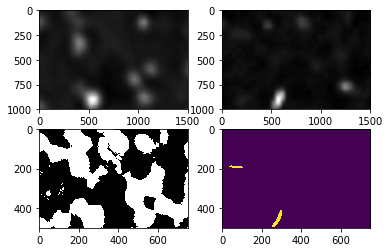

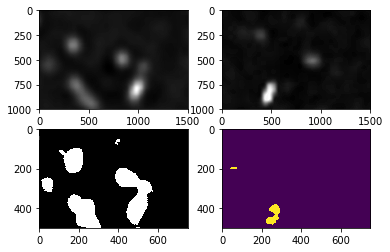

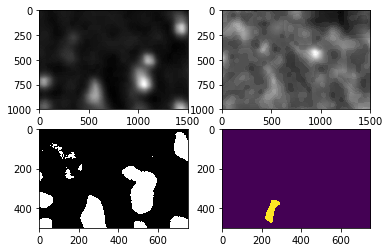

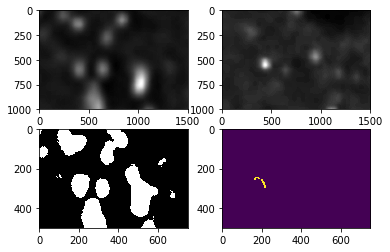

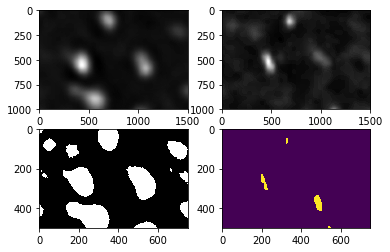

In [34]:
for i in range(5):
    fig = plt.figure()
    fig.add_subplot(221)
    plt.imshow(ave_presyn[i], cmap='gray')
    
    fig.add_subplot(222)
    plt.imshow(ave_postsyn[i], cmap='gray')
    
    fig.add_subplot(223)
    plt.imshow(np.add(downsample_presyn[i], downsample_postsyn[i]) > 0, cmap='gray')
    
    fig.add_subplot(224)
    plt.imshow(pool(annot[i], (2, 2), np.max) > 0)
    plt.show()

# Pre-Alpha 0.0.-1
#### Or, we need to look at it more

In [38]:
synapses = label(annot)

In [41]:
presyn_samples = []
postsyn_samples = []
for curLabel in np.unique(synapses):
    nonzero = np.nonzero(synapses == curLabel)
    z_cent = int(np.mean(nonzero[0]))
    y_cent = int(np.mean(nonzero[1]))
    x_cent = int(np.mean(nonzero[2]))
    d = 25
    presyn_cutout = ave_presyn[z_cent - d: z_cent + d,
                               y_cent - d: y_cent + d,
                               x_cent - d: x_cent + d]
    
    
    postsyn_cutout = ave_presyn[z_cent - d: z_cent + d,
                                y_cent - d: y_cent + d,
                                x_cent - d: x_cent + d]
    
    presyn_samples.append(presyn_cutout)
    postsyn_samples.append(postsyn_cutout)

In [66]:
def get_sample_corr(sample):
    flat = sample.flatten()
    cent = [round(elem/2.) for elem in sample.shape]
    xs = [l2_dist(cent, np.unravel_index(idx, sample.shape)) for idx in range(len(flat))]
    
    #getting rho
    ex = np.mean(xs)
    ei = np.mean(flat)
    
    sx = np.std(xs)
    si = np.std(flat)
    
    if sx == 0 or si == 0:
        return 0
    
    exi = np.mean([xs[i] * flat[i] for i in range(len(flat))])
   
    cov = exi - ex * ei
    corr = cov/(sx * si)
    
    return corr

In [67]:
[get_sample_corr(elem) for elem in presyn_samples]

/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[-0.037524023948908115,
 -0.04931022841421865,
 0.013731759641636993,
 -0.036620096637367518,
 -0.015762485368741815,
 -0.05981853814711998,
 -0.034324118262865785,
 0.04904508721567833,
 0.009562776292297407,
 -0.055550841326333658,
 -0.024704838501751328,
 nan,
 -0.030188372769320682,
 -0.027491122250031683,
 0.018180304258036475,
 -0.022682269883360928,
 -1.3117425831848233e-05,
 0.0089142024175883662,
 -0.026725453902600792,
 -0.011114212957967409]

# Pre-Alpha 0.0.3
#### "do the simplest thing!"

In [78]:
w_presyn = [whiten_chan(elem) for elem in preSyn]
w_postsyn = [whiten_chan(elem) for elem in postSyn]

In [79]:
ave_presyn = np.mean(np.stack(w_presyn), axis=0)
ave_postsyn = np.mean(np.stack(w_postsyn), axis=0)

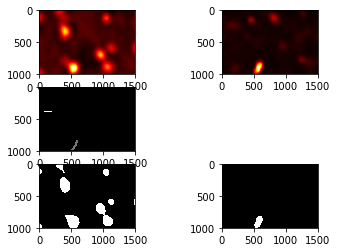

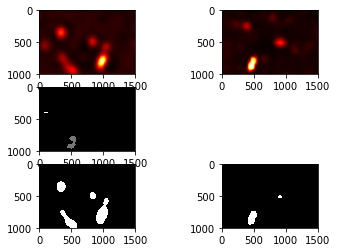

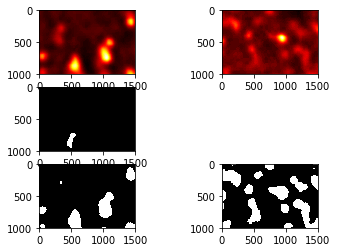

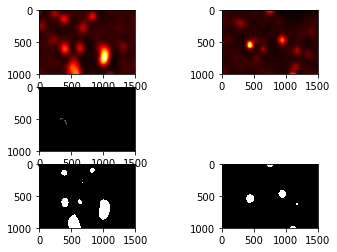

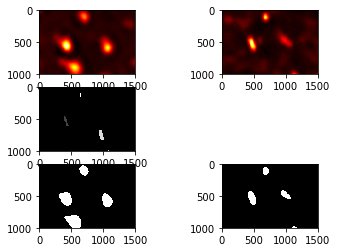

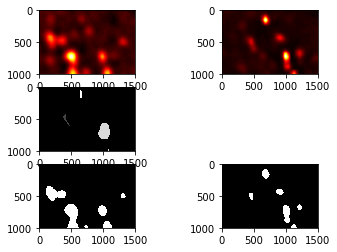

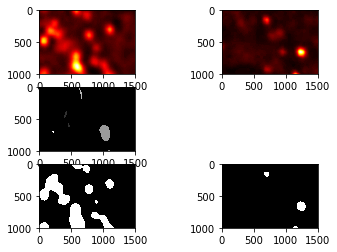

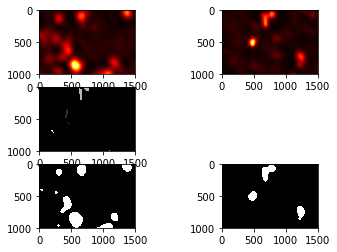

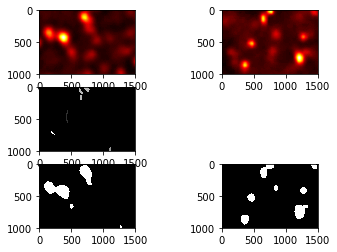

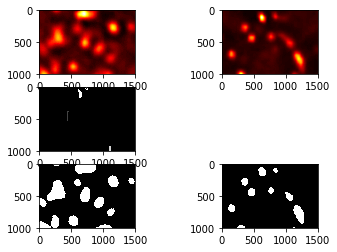

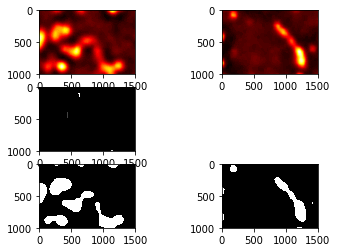

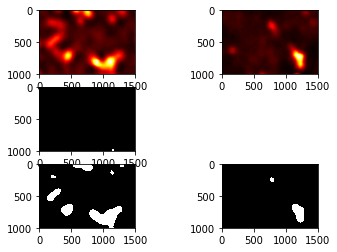

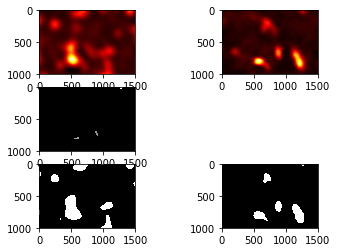

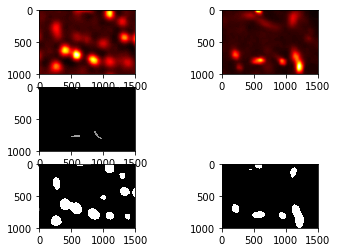

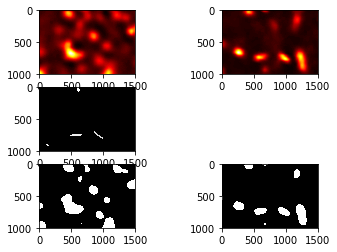

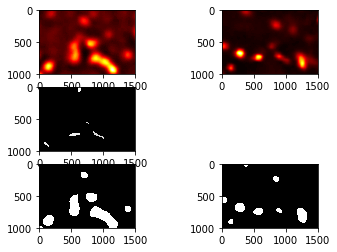

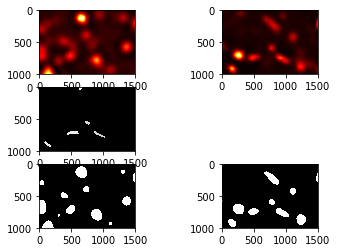

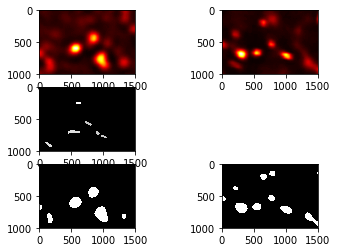

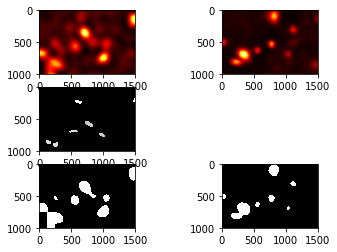

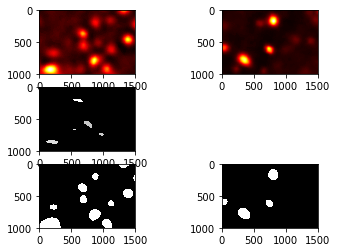

In [92]:
for z in range(preSynAve.shape[0]):
    plt.figure()
    plt.subplot(321)
    plt.imshow(preSynAve[z], cmap='hot')
    
    plt.subplot(322)
    plt.imshow(postSynAve[z], cmap='hot')
    
    plt.subplot(323)
    plt.imshow(annot[z], cmap='gray')
    
    plt.subplot(325)
    plt.imshow(preSynAve[z]> threshold_otsu(preSynAve[z]), cmap='gray')
    
    plt.subplot(326)
    plt.imshow(postSynAve[z]> threshold_otsu(postSynAve[z]), cmap='gray')
    plt.show()

In [98]:
bin_preSyn = np.stack([elem > threshold_otsu(elem) for elem in ave_presyn])
bin_postSyn = np.stack([elem > threshold_otsu(elem) for elem in ave_postsyn])

In [99]:
label_preSyn = label(bin_preSyn)
label_postSyn = label(bin_postSyn)

In [101]:
def get_label_centroid(img, i):
    nonzero = np.nonzero(img == i)
    return np.mean(nonzero[0]), np.mean(nonzero[1]), np.mean(nonzero[2])

In [126]:
centroids_preSyn = []
for idx in np.unique(label_preSyn):
    zc, yc, xc = get_label_centroid(label_preSyn, idx)
    centroids_preSyn.append([zc, yc, xc])

In [127]:
centroids_postSyn = []
for idx in np.unique(label_postSyn):
    zc, yc, xc = get_label_centroid(label_postSyn, idx)
    centroids_postSyn.append([zc, yc, xc])

In [128]:
preSynKD = KDTree(centroids_preSyn)
postSynKD = KDTree(centroids_postSyn)

In [107]:
label_annots = label(annot)

In [152]:
pre_dist = []
for idx in np.unique(label_annots):
    zc, yc, xc = get_label_centroid(label_annots, idx)
    dist, _ = preSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    pre_dist.append(dist[0][0])

In [153]:
post_dist = []
for idx in np.unique(label_annots):
    zc, yc, xc = get_label_centroid(label_annots, idx)
    dist, _ = postSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    post_dist.append(dist[0][0])

In [154]:
pre_rand_dist = []
for _ in range(30):
    zc = np.random.randint(annot.shape[0])
    yc = np.random.randint(annot.shape[1])
    xc = np.random.randint(annot.shape[2])
    
    dist, _ = preSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    pre_rand_dist.append(dist[0][0])

In [155]:
post_rand_dist = []
for _ in range(30):
    zc = np.random.randint(annot.shape[0])
    yc = np.random.randint(annot.shape[1])
    xc = np.random.randint(annot.shape[2])
    
    dist, _ = postSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    post_rand_dist.append(dist[0][0])

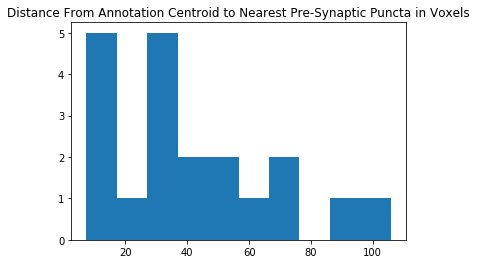

In [156]:
plt.figure()
plt.title('Distance From Annotation Centroid to Nearest Pre-Synaptic Puncta in Voxels')
plt.hist(pre_dist)
plt.show()

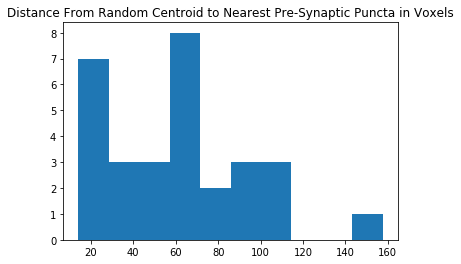

In [157]:
plt.figure()
plt.title('Distance From Random Centroid to Nearest Pre-Synaptic Puncta in Voxels')
plt.hist(pre_rand_dist)
plt.show()

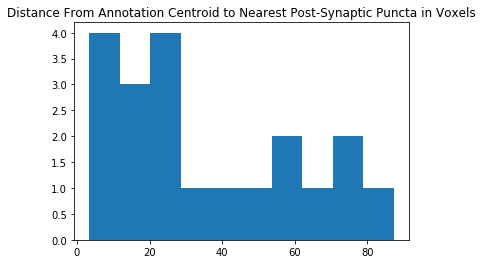

In [158]:
plt.figure()
plt.title('Distance From Annotation Centroid to Nearest Post-Synaptic Puncta in Voxels')
plt.hist(post_dist)
plt.show()

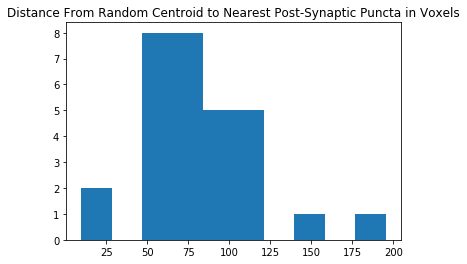

In [159]:
plt.figure()
plt.title('Distance From Random Centroid to Nearest Post-Synaptic Puncta in Voxels')
plt.hist(post_rand_dist)
plt.show()

In [162]:
bi_dist = []
for idx in np.unique(label_annots):
    zc, yc, xc = get_label_centroid(label_annots, idx)
    
    pre_dist, _ = preSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    post_dist, _ = postSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    bi_dist.append(np.mean([pre_dist[0][0], post_dist[0][0]]))

In [168]:
bi_rand_dist = []
for _ in range(100):
    zc = np.random.randint(annot.shape[0])
    yc = np.random.randint(annot.shape[1])
    xc = np.random.randint(annot.shape[2])
    
    pre_dist, _ = preSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    post_dist, _ = postSynKD.query(np.array([zc, yc, xc]).reshape(1, -1), k=1)
    bi_rand_dist.append(np.mean([pre_dist[0][0], post_dist[0][0]]))

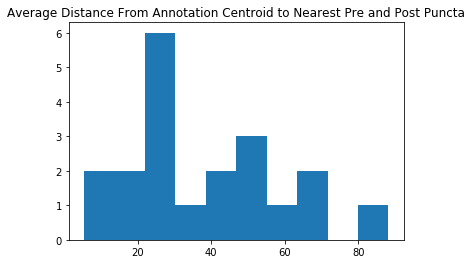

In [164]:
plt.figure()
plt.title('Average Distance From Annotation Centroid to Nearest Pre and Post Puncta')
plt.hist(bi_dist)
plt.show()

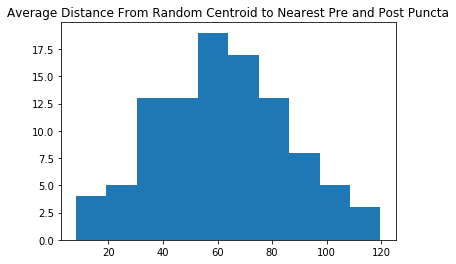

In [169]:
plt.figure()
plt.title('Average Distance From Random Centroid to Nearest Pre and Post Puncta')
plt.hist(bi_rand_dist)
plt.show()